# Boosted Decision Tree (BDT) for $H \rightarrow \rho\gamma, \phi\gamma$ Analysis

In [48]:
# General
import os, sys, json, re
# Handling ROOT files
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import uproot
from uproot_methods import TLorentzVectorArray
import pickle
# Plotting
import matplotlib
from matplottery import Hist1D, Hist2D, plot_stack
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
# Machine Learning
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
import xgboost as xgb #BDT
# Custom Tools
from tools import GetData, CombineYears, BDTtoJSON, JSONtoC
from config import config
# Jupyter Display Settings
%matplotlib inline
pd.set_option('display.max_rows', 20)

## Get Data

In [24]:
# Get dataframes
dfs_2016 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2016/v4-0-0/", pklJar="pickles/2016", mcOnly=True, verbose=False)
dfs_2017 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2017/v4-0-0/", pklJar="pickles/2017", mcOnly=True, verbose=False)
dfs_2018 = GetData("/nfs-7/userdata/jguiang/rare-higgs/2018/v4-0-0/", pklJar="pickles/2018", mcOnly=True, verbose=False)

dfs_add2016 = GetData("/nfs-7/userdata/jguiang/rare-higgs/additional/2016/v4-0-0/", pklJar="pickles/2016", mcOnly=True, verbose=False)
dfs_add2017 = GetData("/nfs-7/userdata/jguiang/rare-higgs/additional/2017/v4-0-0/", pklJar="pickles/2017", mcOnly=True, verbose=False)
dfs_add2018 = GetData("/nfs-7/userdata/jguiang/rare-higgs/additional/2018/v4-0-0/", pklJar="pickles/2018", mcOnly=True, verbose=False)

## Prepare Data

In [25]:
# Concatenate dataframes
dfs = pd.concat(dfs_2016.values()+dfs_2017.values()+dfs_2018.values()+
                dfs_add2016.values()+dfs_add2017.values()+dfs_add2018.values()).reset_index()

# Add Z invariant mass column
lepton_p4 = TLorentzVectorArray.from_ptetaphim(dfs.recoWLepton_pt, dfs.recoWLepton_eta, dfs.recoWLepton_phi, 0.0) # m_lep ~ 0
photon_p4 = TLorentzVectorArray.from_ptetaphim(dfs.recoGamma_pt, dfs.recoGamma_eta, dfs.recoGamma_phi, 0.0)
Z_p4 = lepton_p4+photon_p4
dfs["recoZ_mass"] = Z_p4.mass
# Add bookkeeping columns
dfs["stype"] = dfs.name.astype('category').cat.codes
stypes = dict(set(zip(dfs["name"].values, dfs["stype"].values))) # Dictionary for easy reference
dfs["signal"] = dfs.name.str.contains(config["signal"])

# Drop phi or rho events, cut on mass
if config["analysis"] == "phi":
    dfs = dfs[(dfs.genKp_pt >= 0) | (~dfs.signal)]
    dfs = dfs[(dfs.recoPhi_mass > 1.0) & (dfs.recoPhi_mass < 1.04)]
elif config["analysis"] == "rho":
    dfs = dfs[(np.abs(dfs.genHiggsMeson_id) != 113 ) | (~dfs.signal)]
# Cut on Z mass
dfs = dfs[(dfs.recoZ_mass < 80) | (dfs.recoZ_mass > 95)]
# Choose only reasonable data
dfs = dfs.query("scale1fb > -999 and recoWLepton_pt > 0 and recoPhi_pt > 0 and recoRho_pt > 0 and recoGamma_pt > 0")
# Weigh *_pt columns by reco Higgs mass
cols = list(set(dfs.columns[dfs.columns.str.contains("_pt")])-set(["recoWLepton_pt", "met_pt"])) # *_pt cols
cols_s = [c+"_scaled" for c in cols] # Names of new *_pt_scaled cols
dfs[cols_s] = dfs[cols].div(dfs.recoHiggs_mass, axis=0)
print(dfs.shape)

(54085, 123)


## Get Features for Training

In [26]:
# Get list of branch names
branches = dfs.columns

In [27]:
# Get bookkeeping columns to exclude in training
excludes = ["signal", "stype", "run", "lumi", "event", "scale1fb", "name", "recoMeson_nCands",
            "recoWLepton_nLep", "recoWLepton_nLepVeto", "recoWLepton_id", "isHEM", "isGold",
            "HLT_singleEl", "HLT_singleMu", "passFilters", "recoMagAng_m1", "recoMagAng_m2",
            "entry", "minGammaParton_dR", "recoKp_relIso", "recoKm_relIso","recoKp_eta",
            "recoKm_eta", "recoKp_phi", "recoKm_phi"]
# Add patterned excluded branch names to excludes
pt_re = re.compile("^reco.*_pt$")
for bname in branches:
    if "gen" in bname: excludes.append(bname)
    elif "raw" in bname: excludes.append(bname)
    elif "Higgs" in bname: excludes.append(bname)
    elif re.match(pt_re, bname): excludes.append(bname)
    if config["analysis"] == "phi":
        if "Rho" in bname: excludes.append(bname)
        elif "Pip" in bname: excludes.append(bname)
        elif "Pim" in bname: excludes.append(bname)
        elif "Kp" in bname and "_pt" in bname: excludes.append(bname)
        elif "Km" in bname and "_pt" in bname: excludes.append(bname)
    if config["analysis"] == "rho":
        if "Phi" in bname: excludes.append(bname)
        elif "Kp" in bname: excludes.append(bname)
        elif "Km" in bname: excludes.append(bname)        
# Collect selected features
features = sorted(list(set(dfs.columns.values)-set(excludes)))

In [28]:
# Display selected features
print("{0} Selected Features:\n{1}\n".format(len(features), ", ".join(features)))
# Display excluded features
print("{0} Excluded Features.".format(len(excludes)))

22 Selected Features:
met_phi, met_pt, recoGammaWLepton_dR, recoGamma_eta, recoGamma_phi, recoGamma_pt_scaled, recoGamma_relIso, recoKpKm_dR, recoMagAng_Phi, recoMagAng_Phi1, recoMagAng_cosTheta1, recoMagAng_cosTheta2, recoMagAng_cosThetaStar, recoPhiGamma_dR, recoPhi_eta, recoPhi_mass, recoPhi_phi, recoPhi_pt_scaled, recoPhi_relIso, recoWLepton_eta, recoWLepton_phi, recoZ_mass

111 Excluded Features.


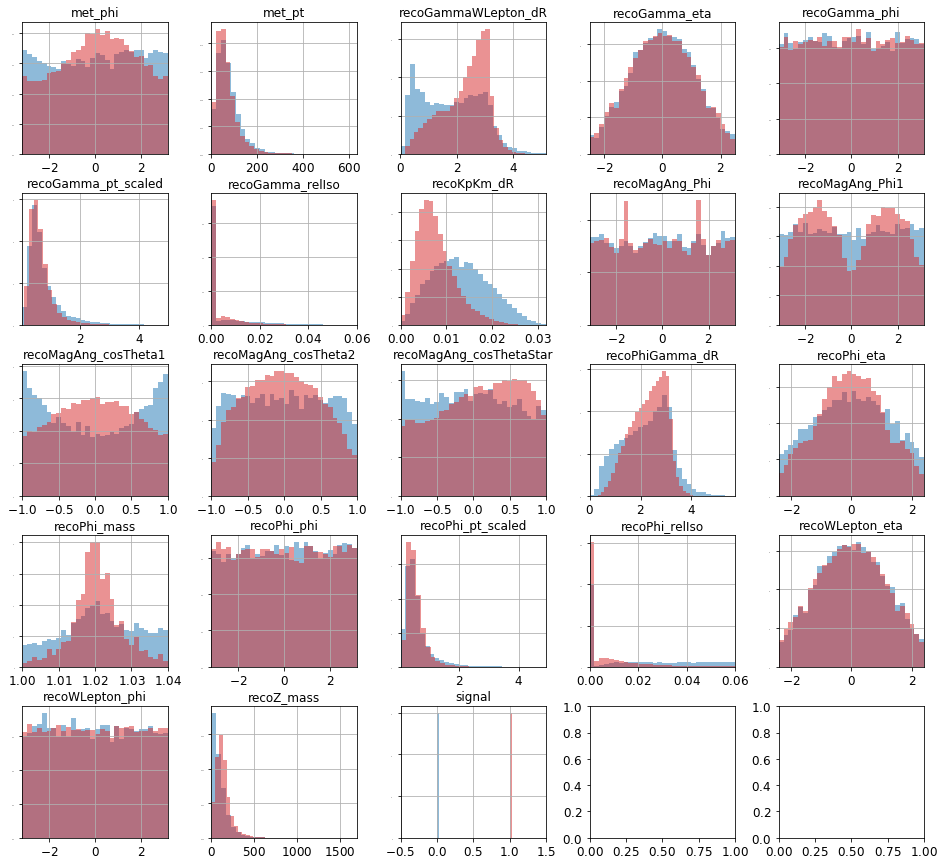

In [54]:
# Plot all columns separately for background and signal
fig, axes = plt.subplots(5,5,figsize=(15,15))
isoPlotReg = ((dfs.recoPhi_relIso < 1) & (dfs.recoGamma_relIso < 1) & (dfs.recoKp_relIso < 1) & (dfs.recoKm_relIso < 1))
ptPlotReg = ((dfs.recoGamma_pt_scaled < 5) & (dfs.recoPhi_pt_scaled < 5))
toPlot = dfs[features+["signal"]][isoPlotReg & ptPlotReg]
ax = toPlot[(toPlot.signal==0)].hist(ax=axes.flatten()[:len(toPlot.keys())], alpha=0.5, color="C0",
                                     ylabelsize=0, density=True, bins=30)
ax = toPlot[(toPlot.signal==1)].hist(ax=axes.flatten()[:len(toPlot.keys())], alpha=0.5, color="C3",
                                     ylabelsize=0, density=True, bins=30)

## Train BDT

In [30]:
# Split dataframe for training and testing
dummyWeights = np.ones(len(dfs["signal"])) # in place of dfs["weights"]
x_train, x_test, y_train, y_test, stype_train, stype_test, weights_train, weights_test = train_test_split(
                dfs,
                dfs["signal"],
                dfs["stype"],
                dfs["scale1fb"],
                test_size=0.25, random_state=42,
                )

In [31]:
print("Training Data: {}".format(x_train.shape))
print("Testing Data: {}".format(x_test.shape))

Training Data: (40563, 123)
Testing Data: (13522, 123)


In [32]:
# BDT Input
dtrain = xgb.DMatrix( x_train[features], label=y_train, weight=np.abs(weights_train))
dtest = xgb.DMatrix( x_test[features], label=y_test, weight=np.abs(weights_test))
evallist = [(dtrain,'train'), (dtest,'eval')]

# BDT Parameters Setup
param = {}
param['objective'] = 'binary:logistic'

# BDT Knobs (Parameters)
num_round = 200                 # Number of training rounds
param['eta'] = 0.1              # Step size shrinkage (alias: learning_rate)
param['max_depth'] = 3          # Max. depth of tree: larger = more complex = more prone to overfitting
param['verbosity'] = 1          # 0 (silent), 1 (warning), 2 (info), 3 (debug)
param['nthread'] = 12           # Number of parallel threads
param['eval_metric'] = "auc"    # Evaluation metrics for validation data. 'auc' = Area Under the Curve
param['subsample'] = 0.6        # Subsample ratio of the training instances
param['alpha'] = 8.0            # L1 regularization term on weights: Larger = more conservative
param['gamma'] = 2.0            # Min. loss rediction to make leaf (alias: min_split_loss)
param['lambda'] = 1.0           # L2 regularization term on weights: Larger = more conservative
param['min_child_weight'] = 1.0 # Minimum sum of instance weight (hessian) needed in a child
param['colsample_bytree'] = 1.0 # The subsample ratio of columns when constructing each tree

In [33]:
# Get pos/neg weights
sumw_pos = np.abs(dtrain.get_weight()[dtrain.get_label()==1]).sum()
sumw_neg = np.abs(dtrain.get_weight()[dtrain.get_label()==0]).sum()
param["scale_pos_weight"] = sumw_neg/sumw_pos

In [34]:
# Train
bst = xgb.train( param.items(), dtrain, num_round, evallist, early_stopping_rounds=15, verbose_eval=False )

## Evaluate Performance

In [35]:
# Get predictions
preds_train = bst.predict(xgb.DMatrix(x_train[features]))
preds_test = bst.predict(xgb.DMatrix(x_test[features]))

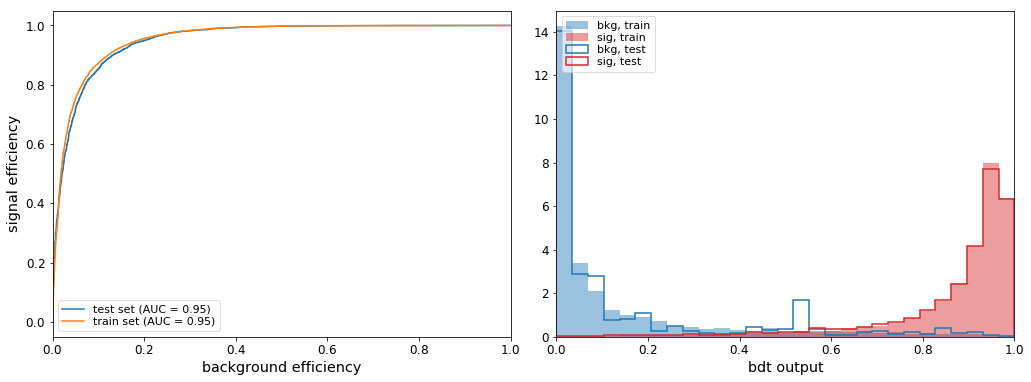

In [36]:
# Suplots setup
fig, axes = plt.subplots(1,2,figsize=(16,6))

# Subplot 1: Plot ROC curves
plt.subplot(1, 2, 1)
# Test ROC Curve
fpr, tpr, thresh = roc_curve(y_test,preds_test)
plt.plot(fpr, tpr, label="test set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Train ROC Curve
fpr, tpr, thresh = roc_curve(y_train,preds_train)
plt.plot(fpr, tpr, label="train set (AUC = {:.2f})".format(np.trapz(tpr,fpr)));
# Settings
plt.xlabel("background efficiency");
plt.ylabel("signal efficiency");
plt.legend();

# Subplot 2: Plot distribution of BDT outputs
plt.subplot(1, 2, 2)
bins = np.linspace(0.,1.,30)
# Training - Background
plt.hist(preds_train[y_train==0], weights=weights_train[y_train==0], bins=bins,histtype="stepfilled",alpha=0.45, 
         density=True, label="bkg, train",color="C0");
# Training - Signal
plt.hist(preds_train[y_train==1], weights=weights_train[y_train==1], bins=bins,histtype="stepfilled",alpha=0.45, 
         density=True, label="sig, train",color="C3");
# Testing - Background
plt.hist(preds_test[y_test==0], weights=weights_test[y_test==0], bins=bins,histtype="step",alpha=1.0, 
         density=True, label="bkg, test",color="C0", lw=1.5, linestyle="solid");
# Testing - Signal
plt.hist(preds_test[y_test==1], weights=weights_test[y_test==1], bins=bins,histtype="step",alpha=1.0, 
         density=True, label="sig, test",color="C3", lw=1.5, linestyle="solid");
# Settings
plt.xlabel("bdt output");
plt.legend(loc=2);

In [59]:
# Get cut scores
gainScore = pd.DataFrame(bst.get_score(importance_type='gain').items(), columns=['cut', 'gain'])
coverScore = pd.DataFrame(bst.get_score(importance_type='cover').items(), columns=['cut', 'cover'])
weightScore = pd.DataFrame(bst.get_score(importance_type='weight').items(), columns=['cut', 'weight'])
# Merge scores into single dataframe along 'cut' column
scores = reduce(lambda left,right: pd.merge(left,right,on='cut'), [gainScore, coverScore, weightScore])
# Display top ten cuts in 'gain'
scores_top10 = scores.sort_values('gain', ascending=False)[:10]
scores_top10

,cut,gain,cover,weight
9,recoPhi_relIso,64.823995,410.500067,57
16,recoKpKm_dR,49.762952,315.353542,143
7,recoZ_mass,34.554528,292.716951,107
21,recoPhi_pt_scaled,30.415027,256.183022,123
8,recoPhi_mass,21.122510,374.886933,79
15,recoPhiGamma_dR,15.631570,256.192849,100
5,recoGamma_pt_scaled,13.298290,179.156460,46
13,recoMagAng_cosTheta1,10.042543,346.471954,58
1,recoGamma_relIso,9.113523,269.280112,38
4,recoMagAng_cosThetaStar,7.324339,188.648235,52


## Check for Higgs Mass Correlation

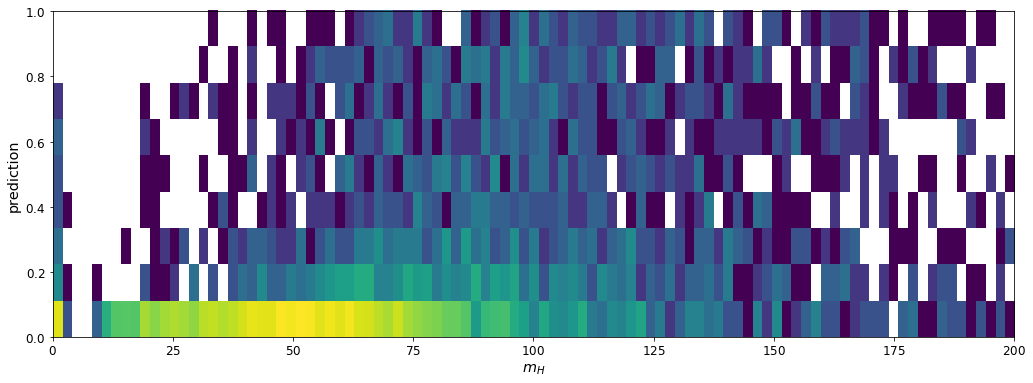

In [38]:
# Suplots setup
fig, axes = plt.subplots(1,1,figsize=(16,6))

# Subplot 1: Plot correlation btwn predictions and Higgs mass
plt.subplot(1, 1, 1)
# Correlation btwn predictions and Higgs mass
h2 = plt.hist2d(x_test["recoHiggs_mass"][x_test.signal == 0], preds_test[y_test == 0], norm=LogNorm(), 
                bins=[np.linspace(0,200,100), np.linspace(0,1,10)]);
# Settings
plt.xlabel("$m_{H}$");
plt.ylabel("prediction");

## Check for Background Sculpting

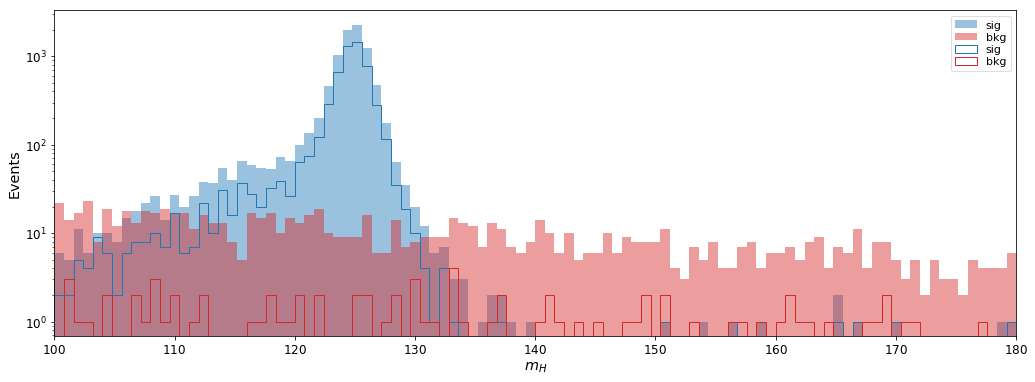

In [63]:
# Suplots setup
fig, axes = plt.subplots(1,1,figsize=(16,6))
bins = np.linspace(100, 180,101)

# Subplot 1: Plot correlation btwn predictions and Higgs mass
plt.subplot(1, 1, 1)
# Correlation btwn predictions and Higgs mass
plt.hist(x_test["recoHiggs_mass"][x_test.signal == 1], bins=bins, histtype="stepfilled",alpha=0.45, label="sig",color="C0")
plt.hist(x_test["recoHiggs_mass"][x_test.signal == 0], bins=bins, histtype="stepfilled",alpha=0.45, label="bkg",color="C3")
plt.hist(x_test["recoHiggs_mass"][(preds_test > 0.9) & (x_test.signal == 1)], bins=bins, histtype="step",alpha=1.0, label="sig",color="C0")
plt.hist(x_test["recoHiggs_mass"][(preds_test > 0.9) & (x_test.signal == 0)], bins=bins, histtype="step",alpha=1.0, label="bkg",color="C3")
# Settings
plt.yscale("log")
plt.xlabel("$m_{H}$");
plt.ylabel("Events");
plt.legend();

## BDT Performance by Sample

In [40]:
data_test = x_test
data_test["bdt"] = preds_test
grouped_dfs = data_test.groupby("name")
grouped_dict = dict((name, grouped_dfs.get_group(name)) for name in dfs.name.unique())
years = ["2016", "2017", "2018"]
dfs_years = [{}, {}, {}]
for name, df in grouped_dict.iteritems():
    for i, y in enumerate(years):
        if y in name:
            dfs_years[i][name] = df
dfs_years[2]["whiggs"] = grouped_dict["whiggs"]

In [41]:
from tools import CombineYears
samples = ["ttg", "ttjets", "wjets", "wgamma", "dyjets", "data"]
regexps = ["^{}.*20.*$".format(mc) for mc in samples[:-1]]
regexps.append("^data_Run20..._(SingleMuon|SingleElectron|EGamma)_.*$")
dfs_test = CombineYears(dfs_years, samples, regexps, signal=config["signal"], verbose=True)

Combining 4 dfs for wgamma
Combining 3 dfs for wjets
Combining 17 dfs for ttjets
Combining 5 dfs for dyjets
Combining 12 dfs for ttg


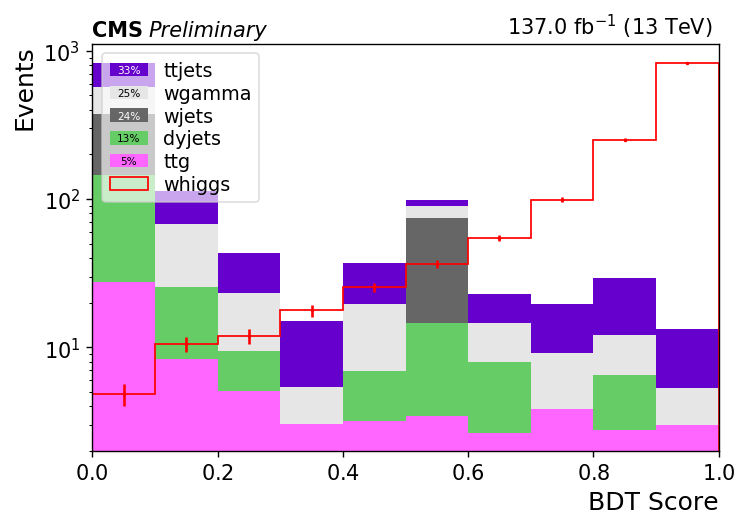

In [42]:
from plots import Plots
plots = Plots(config, dfs_test)
plots.Stacked("bdt", 10, 0,1, xLabel=r"BDT Score", logY=True, save=False)

## Save BDT

In [61]:
# Write BDT to JSON
# BDTtoJSON("bdt.json", bst, features)
# # Create C function that gives BDT predictions
# JSONtoC("bdt.json", "bdt.h")

# # Write BDT model and test data to pickle file
pickle.dump(bst, open("bdt.pkl", "w"))
x_test.to_pickle("x_test.pkl", compression="gzip")
# # Write features to JSON
with open("features.json", "w") as fout:
    json.dump(features, fout)
# Write scores table as LaTeX system
with open("bdt-vars.tex", "w") as fout:
    fout.write(scores_top10.to_latex())